# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

In [2]:
! pip install -q kaggle
from google.colab import files
#upload kaggle.json API akun pribadi
files.upload()
# make directory for save the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Import dataset from kaggle to colab
! kaggle datasets download -d anjay007/penyakit-paru-paru-5-kelas

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anjay007/penyakit-paru-paru-5-kelas
License(s): CC0-1.0
 97% 272M/280M [00:02<00:00, 73.9MB/s]
100% 280M/280M [00:02<00:00, 100MB/s] 


In [3]:
! unzip  /content/penyakit-paru-paru-5-kelas.zip -d lung_disease/
#menghapus zip file dataset
!rm -r /content/penyakit-paru-paru-5-kelas.zip
#menghapus zip file dataset
!rm -r /content/kaggle.json

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_132.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_133.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_135.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_136.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_137.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person29_bacteria_144.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person2_bacteria_3.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_147.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_148.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_149.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_150.jpeg  
  inflati

In [4]:

BASE_DIR = '/content/lung_disease/Lung Disease Dataset'

#Path train, test, dan validation
train = '/content/lung_disease/train_dir'
val = '/content/lung_disease/test_dir'

### Datagenerator

In [5]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 4
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [ ]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 4s 0us/step


### Project Model

In [ ]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(32, activation='relu'))
model_resnet.add(Dense(32, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 time_distributed (TimeDist  (None, 7, 14336)          0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            14812160  
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 256)            394240    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 256)            0         
                                                        

In [ ]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True

callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 169s 321ms/step - loss: 1.6057 - acc: 0.2344 - val_loss: 1.6119 - val_acc: 0.2413
Epoch 2/30
380/380 [==============================] - 119s 312ms/step - loss: 1.5733 - acc: 0.3160 - val_loss: 1.6081 - val_acc: 0.2200
Epoch 3/30
380/380 [==============================] - 117s 309ms/step - loss: 1.5210 - acc: 0.3934 - val_loss: 1.5160 - val_acc: 0.4165
Epoch 4/30
380/380 [==============================] - 119s 312ms/step - loss: 1.4349 - acc: 0.4405 - val_loss: 1.4211 - val_acc: 0.4888
Epoch 5/30
380/380 [==============================] - 117s 309ms/step - loss: 1.3338 - acc: 0.4689 - val_loss: 1.3266 - val_acc: 0.5244
Epoch 6/30
380/380 [==============================] - 117s 308ms/step - loss: 1.2507 - acc: 0.4877 - val_loss: 1.2452 - val_acc: 0.5346
Epoch 7/30
380/380 [==============================] - 119s 313ms/step - loss: 1.1837 - acc: 0.5158 - val_loss: 1.1787 - val_acc: 0.5631
Epoch 8/30
380/380 [============================

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

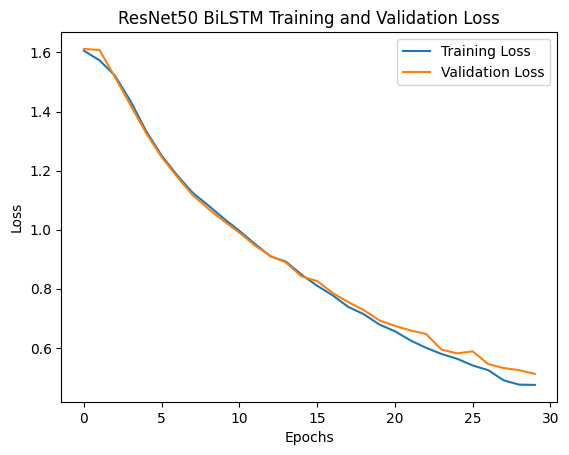

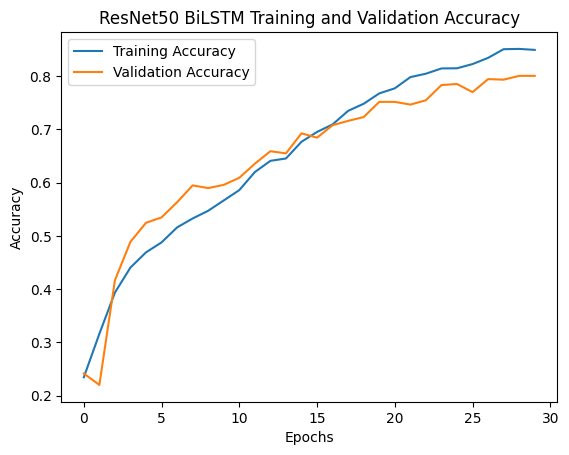

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 7s 28ms/step - loss: 0.5120 - acc: 0.8004
Loss: 0.512037456035614
Accuracy: 0.800407350063324


In [ ]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 95s 244ms/step

ResNet50 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19933   0.19426   0.19676      1220
            covid19    0.21863   0.22285   0.22072      1243
             normal    0.20960   0.20162   0.20553      1235
       tuberculosis    0.18593   0.18291   0.18440      1170
    viral_pneumonia    0.21946   0.23267   0.22587      1212

           accuracy                        0.20707      6080
          macro avg    0.20659   0.20686   0.20666      6080
       weighted avg    0.20679   0.20707   0.20686      6080



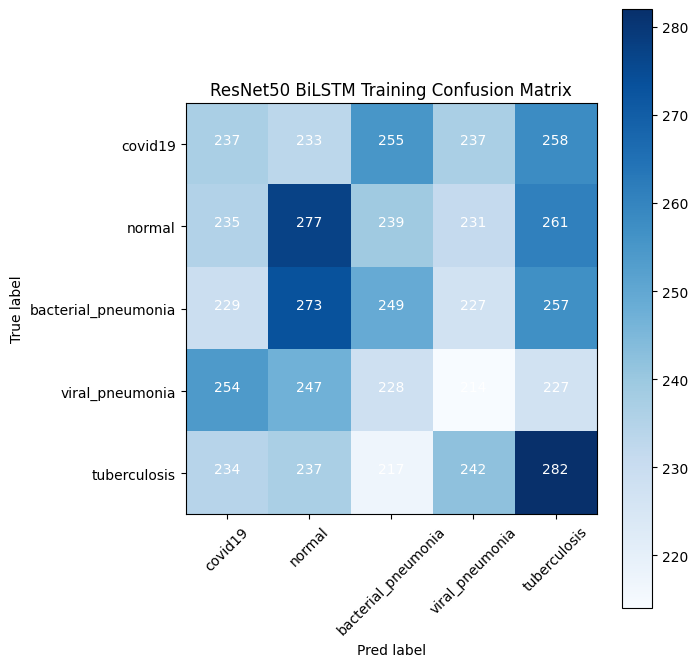

In [ ]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [ ]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True

80134624/80134624 [==============================] - 5s 0us/step


### Our Model

In [ ]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(32, activation='relu'))
model_VGG19.add(Dense(32, activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 time_distributed_1 (TimeDi  (None, 7, 3584)           0         
 stributed)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 7, 256)            3802112   
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 7, 256)            394240    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 7, 256)            0         
                                                      

In [ ]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
  6/380 [..............................] - ETA: 1:36 - loss: 1.5999 - acc: 0.1979

380/380 [==============================] - 159s 352ms/step - loss: 1.5932 - acc: 0.2595 - val_loss: 1.5409 - val_acc: 0.3676
Epoch 2/30
380/380 [==============================] - 131s 343ms/step - loss: 1.4721 - acc: 0.4148 - val_loss: 1.3541 - val_acc: 0.5295
Epoch 3/30
380/380 [==============================] - 129s 340ms/step - loss: 1.2845 - acc: 0.5462 - val_loss: 1.1859 - val_acc: 0.5937
Epoch 4/30
380/380 [==============================] - 130s 342ms/step - loss: 1.1423 - acc: 0.6021 - val_loss: 1.0785 - val_acc: 0.6670
Epoch 5/30
380/380 [==============================] - 128s 338ms/step - loss: 1.0455 - acc: 0.6429 - val_loss: 0.9774 - val_acc: 0.7149
Epoch 6/30
380/380 [==============================] - 129s 338ms/step - loss: 0.9635 - acc: 0.6789 - val_loss: 0.8840 - val_acc: 0.7536
Epoch 7/30
380/380 [==============================] - 129s 339ms/step - loss: 0.9015 - acc: 0.6890 - val_loss: 0.8294 - val_acc: 0.7648
Epoch 8/30
380/380 [==============================] - 130s 

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

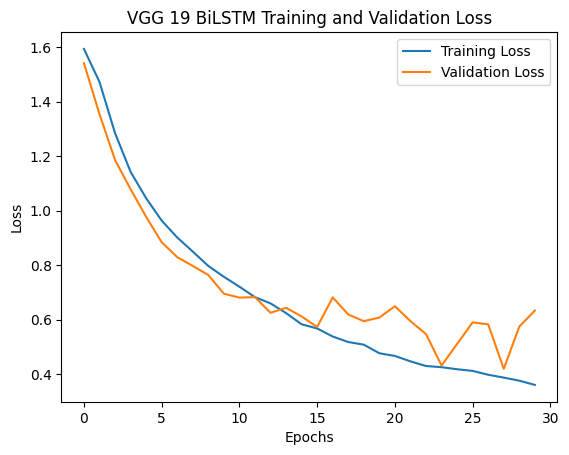

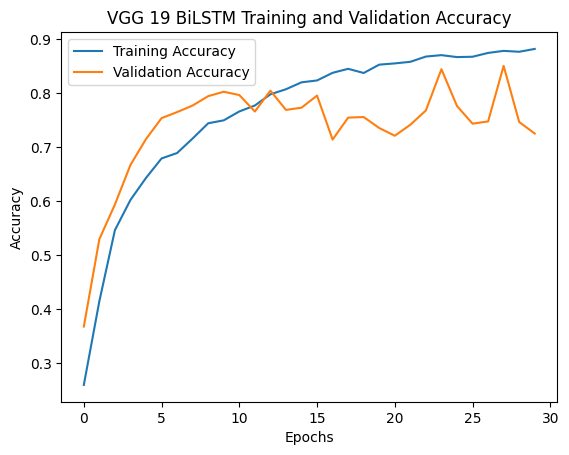

In [ ]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 9s 36ms/step - loss: 0.6336 - acc: 0.7251
Loss: 0.6336018443107605
Accuracy: 0.7250509262084961


In [ ]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 94s 243ms/step

VGG 19 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21290   0.24344   0.22715      1220
            covid19    0.20360   0.20917   0.20635      1243
             normal    0.20405   0.19595   0.19992      1235
       tuberculosis    0.18701   0.18462   0.18581      1170
    viral_pneumonia    0.21649   0.19059   0.20272      1212

           accuracy                        0.20493      6080
          macro avg    0.20481   0.20475   0.20439      6080
       weighted avg    0.20494   0.20493   0.20454      6080



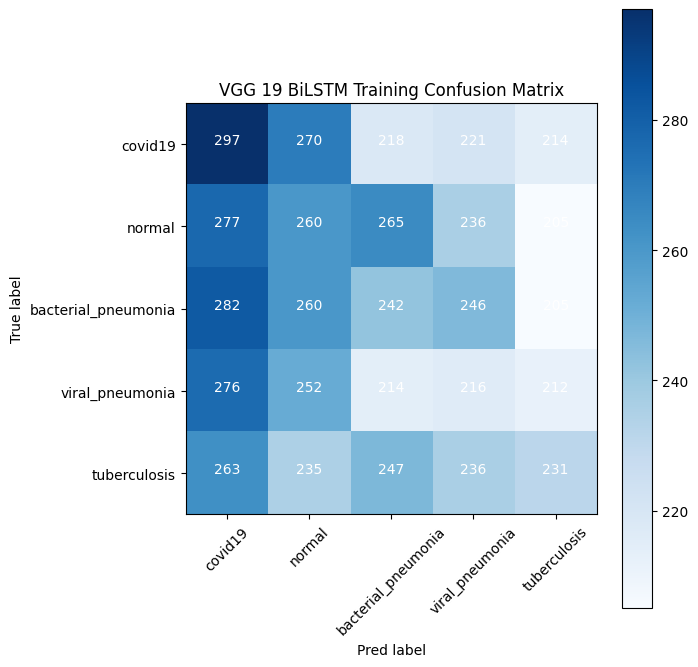

In [ ]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [6]:
InceptionV3_model = InceptionV3(weights='imagenet',
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(32, activation='relu'))
model_InceptionV3.add(Dense(32, activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 time_distributed (TimeDist  (None, 5, 10240)          0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 5, 256)            10617856  
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 256)            394240    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                        

In [8]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 174s 320ms/step - loss: 1.6032 - acc: 0.2349 - val_loss: 1.5924 - val_acc: 0.2851
Epoch 2/30
380/380 [==============================] - 113s 297ms/step - loss: 1.5774 - acc: 0.2926 - val_loss: 1.5624 - val_acc: 0.3391
Epoch 3/30
380/380 [==============================] - 114s 299ms/step - loss: 1.5197 - acc: 0.3771 - val_loss: 1.4914 - val_acc: 0.4308
Epoch 4/30
380/380 [==============================] - 111s 293ms/step - loss: 1.4376 - acc: 0.4270 - val_loss: 1.4016 - val_acc: 0.4898
Epoch 5/30
380/380 [==============================] - 113s 297ms/step - loss: 1.3493 - acc: 0.4673 - val_loss: 1.3058 - val_acc: 0.5305
Epoch 6/30
380/380 [==============================] - 112s 294ms/step - loss: 1.2643 - acc: 0.4951 - val_loss: 1.2277 - val_acc: 0.5672
Epoch 7/30
380/380 [==============================] - 113s 296ms/step - loss: 1.1985 - acc: 0.5220 - val_loss: 1.1520 - val_acc: 0.6029
Epoch 8/30
380/380 [============================

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

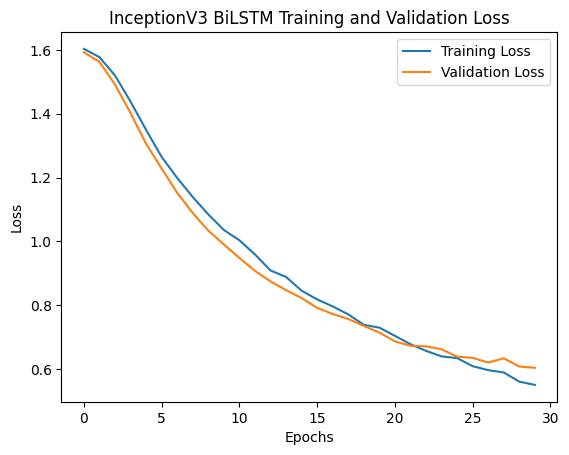

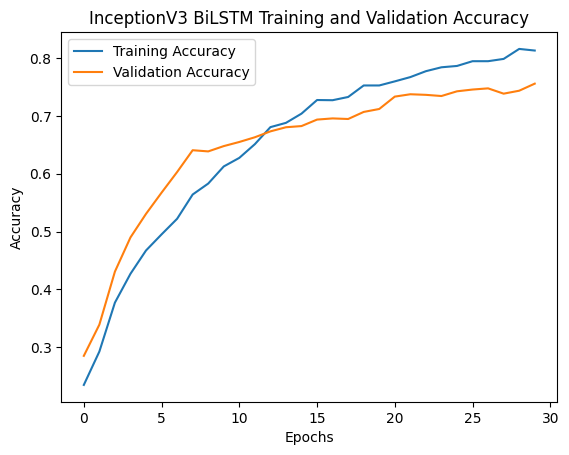

In [9]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 11s 46ms/step - loss: 0.6033 - acc: 0.7556
Loss: 0.6033399105072021
Accuracy: 0.7556008100509644


In [11]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 100s 250ms/step

InceptionV3 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.18715   0.19098   0.18905      1220
            covid19    0.20316   0.19630   0.19967      1243
             normal    0.19291   0.18947   0.19118      1235
       tuberculosis    0.17647   0.17692   0.17670      1170
    viral_pneumonia    0.19712   0.20297   0.20000      1212

           accuracy                        0.19145      6080
          macro avg    0.19136   0.19133   0.19132      6080
       weighted avg    0.19153   0.19145   0.19146      6080



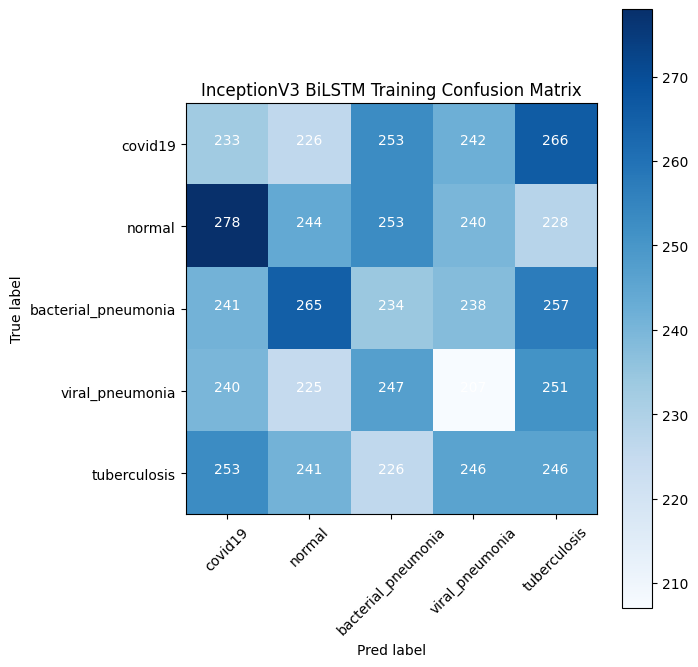

In [12]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()